In [2]:
startupMode = 'dev'

if startupMode == 'colab':
    try:
		    import xfads,jax,gpytorch
    except ImportError:
        %pip install --quiet pytorch-lightning hydra-core
        %pip install --quiet gpytorch
        %pip install git+https://github.com/catniplab/xfads
        %git clone https://github.com/catniplab/xfads
        %cd xfads/examples/ring_attractor
        config_path = "../content/xfads/examples/ring_attractor"
elif startupMode == 'dev':
    import sys
    sys.path.append('../..') # add path for xfads root

    %load_ext autoreload
    %autoreload 2
    config_path = ''

In [3]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL, LowRankNonlinearStateSpaceModel

import numpy as np

## ⚙️ 2. Initialize Configuration

We use Hydra to load experiment configs and set up deterministic behavior for reproducibility.

In [4]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path=config_path, job_name="lds")
cfg = compose(config_name="config")

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

Seed set to 1234


In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

cfg['device'] = device
print(f"Using device: {device}")

# w quick test
matrix_a = torch.randn(1024, 1024, device=device)
result = torch.matmul(matrix_a, matrix_a)

cfg['n_epochs'] = 100  # reduced epochs for testing

Using device: cpu


## 📈 3. Simulate Data

We generate data from a 2D ring attractor latent dynamic system, projecting into 100-dimensional observations using a fixed linear readout.

In [6]:
import importlib.util

file_path = "./test_dynamics.py"
module_name = "test_dynamics"  # can be any name

spec = importlib.util.spec_from_file_location(module_name, file_path)
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

In [7]:
perturbation_magnitude=0.1

n_trials = 3000
n_neurons = 100
n_time_bins = 75


# Backup RNG states
cpu_state = torch.get_rng_state()
cuda_state = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
np_state = np.random.get_state()

mean_fn = PerturbedRingAttractorDynamics(bin_sz=1e-1,lengthscale=0.2,perturbation_magnitude=perturbation_magnitude).to(cfg.device)

# Restore RNG states
torch.set_rng_state(cpu_state)
if cuda_state is not None:
    torch.cuda.set_rng_state_all(cuda_state)
np.random.set_state(np_state)

C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)

Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=cfg.device)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=cfg.device)
R_diag = 1e-1 * torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


## 📈 4. Visualize Latent Trajectories

Let's look at some sample trajectories from the 2D latent space.


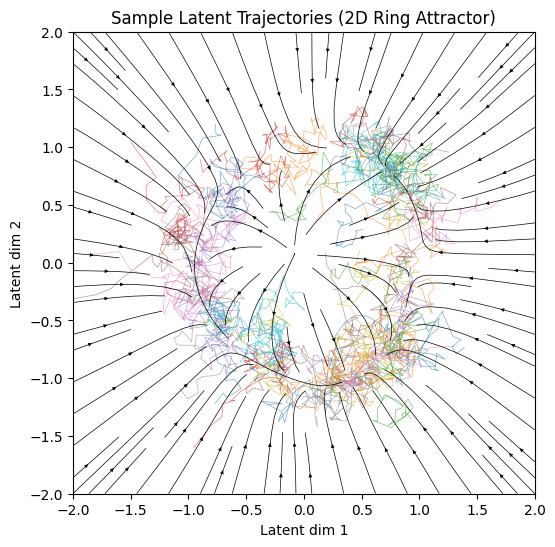

In [8]:
fig, axs = plt.subplots(figsize=(6, 6))
for i in range(40):
    axs.plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)

plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), axs, min_xy=-2, max_xy=2)
axs.set_title("Sample Latent Trajectories (2D Ring Attractor)")
axs.set_xlabel("Latent dim 1")
axs.set_ylabel("Latent dim 2")
axs.set_xlim(-2, 2)
axs.set_ylim(-2, 2)
axs.set_box_aspect(1.0)
plt.show()
fig.savefig(
    f'latent_traj_perturb_{perturbation_magnitude}.png',
    dpi=300, bbox_inches='tight'
)

##  5. Prepare Train/Validation Dataloaders

Split the simulated data into training and validation sets and prepare PyTorch dataloaders.


In [9]:
def collate_fn(batch):
    elem = batch[0]
    if isinstance(elem, (tuple, list)):
        return tuple(torch.stack([b[i] for b in batch]).to(cfg.device) for i in range(len(elem)))
    else:
        return torch.stack(batch).to(cfg.device)

y_train, z_train = y[:2*n_trials//3], z[:2*n_trials//3]
y_valid, z_valid = y[2*n_trials//3:], z[2*n_trials//3:]

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), batch_size=cfg.batch_sz, shuffle=True, collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), batch_size=cfg.batch_sz, shuffle=False, collate_fn=collate_fn
)

## 🧱 6. Define Model Components

We define the following:
- A Gaussian likelihood with a fixed observation noise
- A nonlinear Gaussian dynamics module
- A prior over the initial condition
- Local and backward encoders for amortized inference

In [10]:
# Likelihood
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, C)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=cfg.device, fix_R=True)

# Dynamics
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)

## 🧠 7. Assemble the State Space Model

We combine dynamics, likelihood, encoders, and filtering into a complete latent variable model.

In [11]:
ssm = LowRankNonlinearStateSpaceModel(
    dynamics_mod, likelihood_pdf, initial_condition_pdf,
    backward_encoder, local_encoder, nl_filter, device=cfg.device
)

## 🔁 8. Train the Model Using PyTorch Lightning

We use `LightningNonlinearSSM` for training. Logging and checkpointing are included.


In [12]:
from pytorch_lightning.callbacks import Timer
timer = Timer()

In [13]:
train_from_scratch = True

if train_from_scratch:
    seq_vae = LightningNonlinearSSM(ssm, cfg)

    csv_logger = CSVLogger('logs/', name=f'r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='noncausal')
    ckpt_callback = ModelCheckpoint(
        save_top_k=3, monitor='valid_loss', mode='min',
        dirpath='ckpts/', filename='{epoch:0}_{valid_loss:.2f}'
    )
    early_stop_callback = EarlyStopping(monitor="valid_loss", min_delta=0.00, patience=5, verbose=False, mode="min")

    trainer = pl.Trainer(
        max_epochs=cfg.n_epochs,
        gradient_clip_val=1.0,
        default_root_dir='lightning/',
        callbacks=[ckpt_callback,timer,early_stop_callback],
        accelerator=cfg.device,  # disable autodetection (no MPS support!)
        logger=csv_logger
    )

    trainer.fit(model=seq_vae, train_dataloaders=train_loader, val_dataloaders=valid_loader)
    torch.save(ckpt_callback.best_model_path, 'ckpts/best_model_path.pt')
    seq_vae = LightningNonlinearSSM.load_from_checkpoint(ckpt_callback.best_model_path, ssm=ssm, cfg=cfg)

else:
    seq_vae = LightningNonlinearSSM.load_from_checkpoint('ckpts/example_model.ckpt', ssm=ssm, cfg=cfg)
    
seq_vae = seq_vae.to('cpu')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/r_y_2_r_b_2/noncausal exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/artliang/Documents/symm_reg/in_progress/ckpts exists and is not empty.

  | Name | Type                            | Params
---------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 41.2 K
---------------------------------------------------------
40.9 K    Trainable params
300       Non-trainable params
41.2 K    Total params
0.165     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [14]:
print(timer.time_elapsed("train"))  # total training time
print(timer.time_elapsed("validate"))  # validation time

983.8424353750015
11.547184499999275


## ✅ Done!

The model is now trained. You can proceed with:
- Plotting smoothed trajectories.
- Visualizing uncertainty.
- Comparing inferred vs. ground truth latents (since this was a synthetic dataset).


In [18]:
# Infer latent trajectories from contaminated observations
seq_vae.eval()
with torch.no_grad():
    _, z_inferred_samples, _ = seq_vae.ssm(y, cfg.n_samples)
    z_inferred = z_inferred_samples.mean(dim=0)

print(f"✅ Inferred latents from contaminated observations")
print(f"   Inferred shape: {z_inferred.shape}")
print(f"   True shape: {z.shape}")

# Compute basic metrics
mse = torch.mean((z_inferred - z)**2).item()
correlation = torch.corrcoef(torch.stack([z.flatten(), z_inferred.flatten()]))[0, 1].item()

print(f"📊 Recovery metrics:")
print(f"   MSE: {mse:.6f}")
print(f"   Correlation: {correlation:.4f}")

✅ Inferred latents from contaminated observations
   Inferred shape: torch.Size([3000, 75, 2])
   True shape: torch.Size([3000, 75, 2])
📊 Recovery metrics:
   MSE: 0.010487
   Correlation: 0.9918


## 🌀 9. Visualize Learned Dynamics and Simulated Trajectories

Now that training is complete, we can explore what the model has learned.  
This section:
- Seeds the latent space with initial conditions.
- Rolls out the learned dynamics forward in time.
- Overlays those trajectories onto the learned dynamics vector field.
python
Copy
Edit


In [15]:
# Define number of rollout samples and rollout length
n_ex_samples = 1
n_ex_trials = 50
n_ex_time_bins = 50

# Sample initial latent states (z_0): a mix of small and large amplitude noise
z_0 = torch.zeros((n_ex_samples, n_ex_trials, 2))
z_0[:, ::2] = 0.2 * torch.randn_like(z_0[:, ::2])   # small amplitude for even-indexed trials
z_0[:, 1::2] = 2.0 * torch.randn_like(z_0[:, 1::2])  # large amplitude for odd-indexed trials

# Predict forward using the learned dynamics (no encoder or data used here)
z_prd = seq_vae.ssm.predict_forward(z_0, n_ex_time_bins).detach()

### 🧭 Plot: Learned Dynamics Vector Field + Predicted Latent Trajectories

The vector field shows the learned mean dynamics function.
Each curve shows a rollout of the model's latent trajectory starting from a different `z_0`.
    

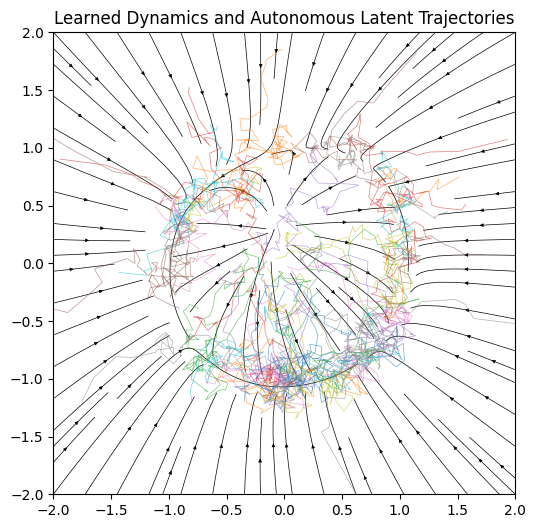

In [16]:
fig, axs = plt.subplots(figsize=(6, 6))
axs.set_box_aspect(1.0)
axs.set_xlim(-2.0, 2.0)
axs.set_ylim(-2.0, 2.0)
axs.set_title("Learned Dynamics and Autonomous Latent Trajectories")

# Plot learned vector field over the 2D latent space
plot_utils.plot_two_d_vector_field(
    seq_vae.ssm.dynamics_mod.mean_fn,
    axs,
    min_xy=-2,
    max_xy=2,
)

# Overlay predicted trajectories
for i in range(50):  # plot 50 of the 50
    axs.plot(z_prd[0, i, :, 0].cpu(), z_prd[0, i, :, 1].cpu(), lw=0.5, alpha=0.6)

plt.show()
fig.savefig(
    f'learned_traj_perturb_{perturbation_magnitude}.png',
    dpi=300, bbox_inches='tight'
)

/var/folders/20/sydjdg052fld_b2zzxcwvf540000gn/T/ipykernel_48254/3085170732.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12)


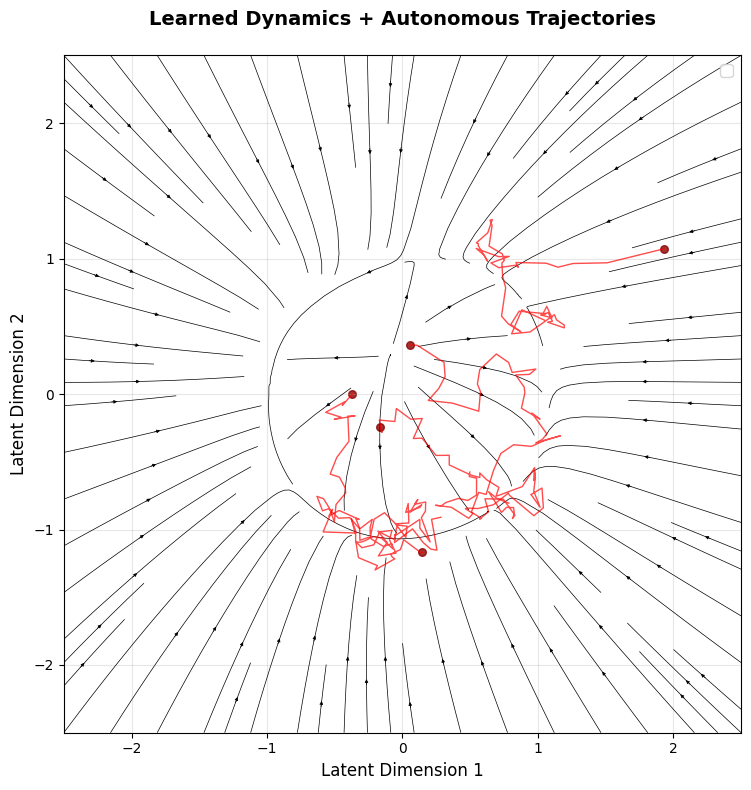

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_box_aspect(1.0)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_title("Learned Dynamics + Autonomous Trajectories\n", fontweight='bold', fontsize=14)

# Plot learned vector field
plot_utils.plot_two_d_vector_field(
    seq_vae.ssm.dynamics_mod.mean_fn, ax, min_xy=-2.5, max_xy=2.5
)

# Overlay autonomous trajectories from learned dynamics
for i in range(5):  # plot subset for clarity
    ax.plot(z_prd[0, i, :, 0].cpu(), z_prd[0, i, :, 1].cpu(), 
           lw=1, alpha=0.7, color='red')
    # Mark starting points
    ax.scatter(z_prd[0, i, 0, 0].cpu(), z_prd[0, i, 0, 1].cpu(), 
              s=30, alpha=0.8, color='darkred')

# Plot true ring manifold for reference
# ax.plot(inv_man[:, 0], inv_man[:, 1], 'b-', linewidth=4, alpha=0.9, label='True Ring Manifold')

ax.set_xlabel('Latent Dimension 1', fontsize=12)
ax.set_ylabel('Latent Dimension 2', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

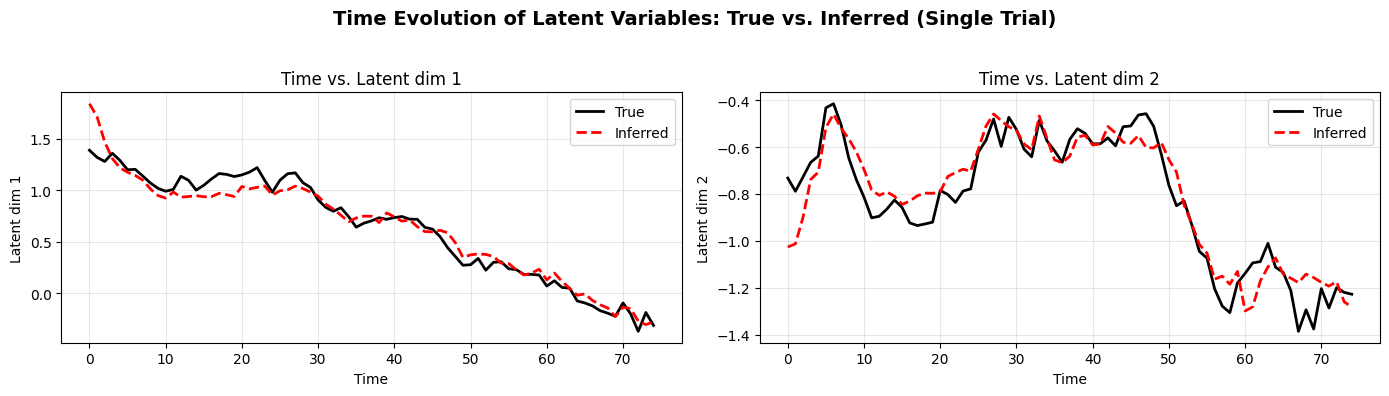

In [24]:
trial_idx = 0  # Plot for the first trial; change as needed
T = z.shape[1]
time = np.arange(T)

fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
for dim in range(2):
    axs[dim].plot(time, z[trial_idx, :, dim].cpu(), label='True', color='black', lw=2)
    axs[dim].plot(time, z_inferred[trial_idx, :, dim].cpu(), label='Inferred', color='red', lw=2, linestyle='--')
    axs[dim].set_xlabel('Time')
    axs[dim].set_ylabel(f'Latent dim {dim+1}')
    axs[dim].set_title(f'Time vs. Latent dim {dim+1}')
    axs[dim].legend()
    axs[dim].grid(True, alpha=0.3)
plt.suptitle('Time Evolution of Latent Variables: True vs. Inferred (Single Trial)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

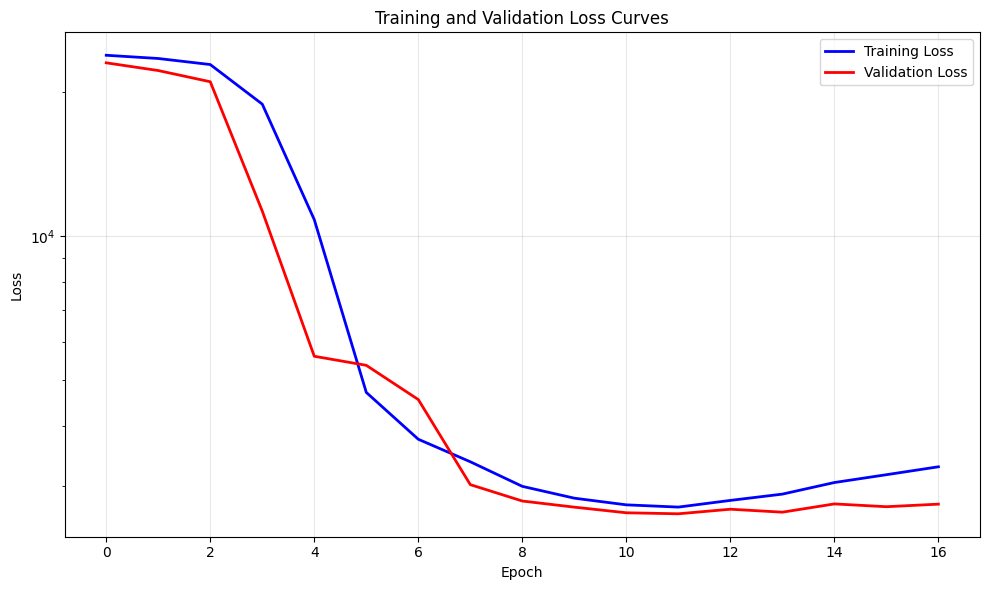

Loss curve saved as 'loss_curve.png'


In [ ]:
import pandas as pd

# Read the metrics CSV
df = pd.read_csv('/Users/artliang/Documents/symm_reg/in_progress/logs/r_y_2_r_b_2/noncausal/metrics.csv')

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training loss (remove NaN values)
train_mask = ~df['train_loss'].isna()
plt.plot(df[train_mask]['epoch'], df[train_mask]['train_loss'], 'b-', label='Training Loss', linewidth=2)

# Plot validation loss (remove NaN values)
valid_mask = ~df['valid_loss'].isna()
plt.plot(df[valid_mask]['epoch'], df[valid_mask]['valid_loss'], 'r-', label='Validation Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Use log scale for better visualization
plt.tight_layout()

# Save the plot
plt.savefig('/Users/artliang/Documents/symm_reg/in_progress/loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Loss curve saved as 'loss_curve.png'")